In [1]:
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
import os
from train_model_debugging import BTCVSliceDataset, VolumeCache, train_model
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data_path = "/home/ismail/projet_PFE//data/RawData"
train_set = pd.read_csv(os.path.join(data_path, "split", "test_dataset.csv"))
train_volume_cache = VolumeCache(train_set)

Loading all image volumes into cache: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


In [12]:
train_dataset = BTCVSliceDataset(
    train_set,
    "liver",
    train_volume_cache,
    organ_threshold=0.1,
    binary=True,
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

Loading masks: 100%|██████████| 5/5 [00:00<00:00,  9.96it/s]

Average white percentage for liver: 0.0696
Total slices found: 277
Total slices kept: 239


next step is to check the train loop :
- input to model
- model output
- metrics
- why the moel peaks at first?

In [14]:
from torchvision.ops import sigmoid_focal_loss
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
import sys

sys.path.append("../Unet")
from unet import UNet

In [15]:
def dice_coefficient(y_pred, y_true, smooth=1e-6):
    """Calculate Dice coefficient"""
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    return (2.0 * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

In [16]:
phases = ["train"]
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# ## HERE WE USE : focal loss, probs > 0.5
# for epoch in tqdm(range(5), desc="Training Epochs"):
#     # Each epoch has training and validation phase
#     for phase in phases:
#         if phase == "train":
#             model.train()
#             dataloader = train_loader
#         elif phase == "val":
#             model.eval()
#             dataloader = val_loader
#             all_val_preds = []
#             all_val_masks = []

#         running_loss = 0.0
#         running_dice = 0.0

#         for volumes, masks in tqdm(train_loader, desc=f"{phase.capitalize()} phase"):
#             volumes = volumes.to(device)
#             masks = masks.to(device)

#             # Zero the gradients
#             optimizer.zero_grad()

#             # Forward pass
#             with torch.set_grad_enabled(phase == "train"):
#                 outputs = model(volumes)
#                 probs = torch.sigmoid(outputs)
#                 preds = (probs > 0.5).float()
#                 # --- PLOTTING CODE ---
#                 # Move tensors to CPU and detach from graph for plotting
#                 volumes_cpu = volumes.cpu().numpy()
#                 masks_cpu = masks.cpu().numpy()
#                 preds_cpu = preds.cpu().detach().numpy()

#                 for i in range(volumes.size(0)):  # Iterate through batch
#                     plt.figure(figsize=(15, 5))

#                     # Plot Input Image
#                     plt.subplot(1, 3, 1)
#                     plt.imshow(volumes_cpu[i].squeeze(), cmap="gray")
#                     plt.title("Input Image")
#                     plt.axis("off")

#                     # Plot Ground Truth Mask
#                     plt.subplot(1, 3, 2)
#                     plt.imshow(masks_cpu[i].squeeze(), cmap="gray")
#                     plt.title("Ground Truth Mask")
#                     plt.axis("off")

#                     # Plot Predicted Mask
#                     plt.subplot(1, 3, 3)
#                     plt.imshow(preds_cpu[i].squeeze(), cmap="gray")
#                     plt.title("Predicted Mask")
#                     plt.axis("off")

#                     plt.show()
#                     plt.close()
#                     break
#                 # --- END PLOTTING ---
#                 # Calculate loss
#                 loss = sigmoid_focal_loss(outputs, masks, reduction="mean")

#                 # Calculate Dice score
#                 dice = dice_coefficient(preds, masks)

#                 # Backward + optimize only in training phase
#                 if phase == "train":
#                     loss.backward()
#                     optimizer.step()

#             # Statistics
#             running_loss += loss.item() * volumes.size(0)
#             running_dice += dice * volumes.size(0)

#             if phase == "val":
#                 all_val_preds.append(preds.view(-1).cpu())
#                 all_val_masks.append(masks.view(-1).cpu())

#         # Calculate epoch metrics
#         epoch_loss = running_loss / len(dataloader.dataset)
#         epoch_dice = running_dice / len(dataloader.dataset)

#         print(f"{phase} Loss: {epoch_loss:.4f} Dice: {epoch_dice:.4f}")

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

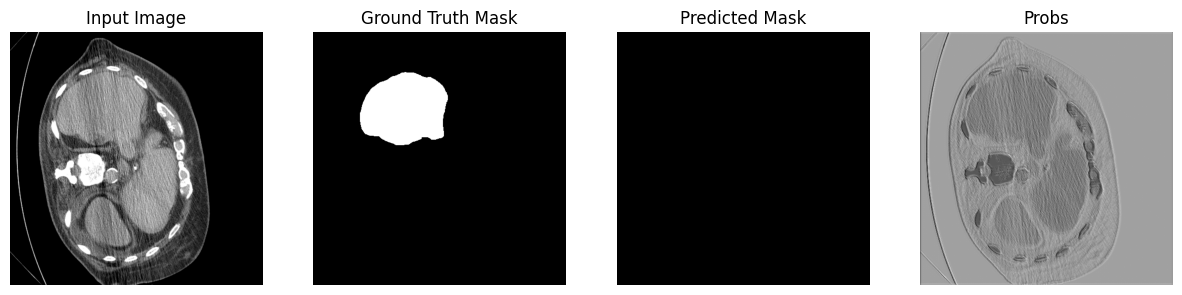

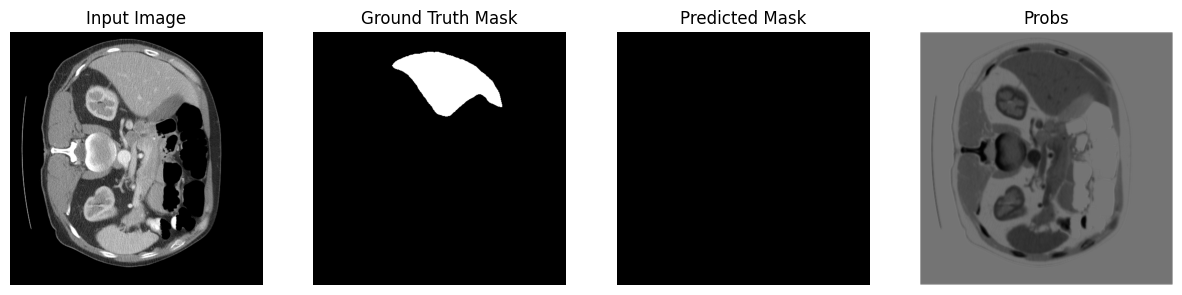

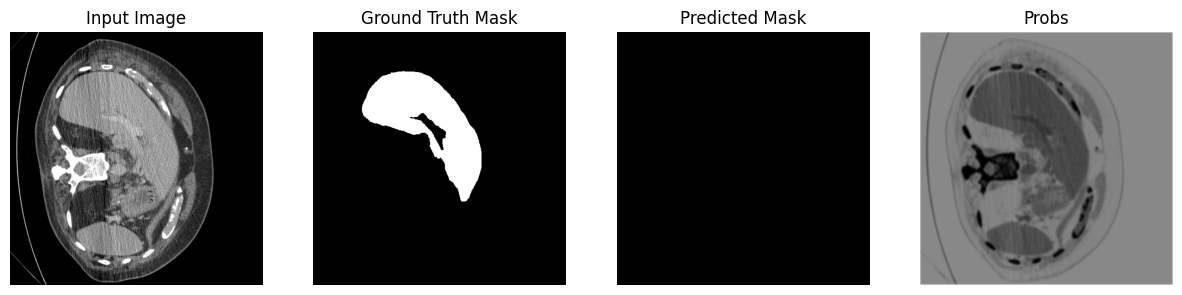

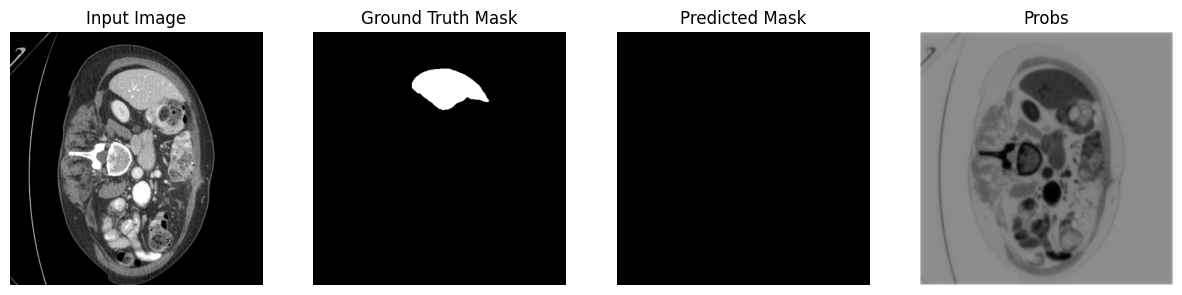

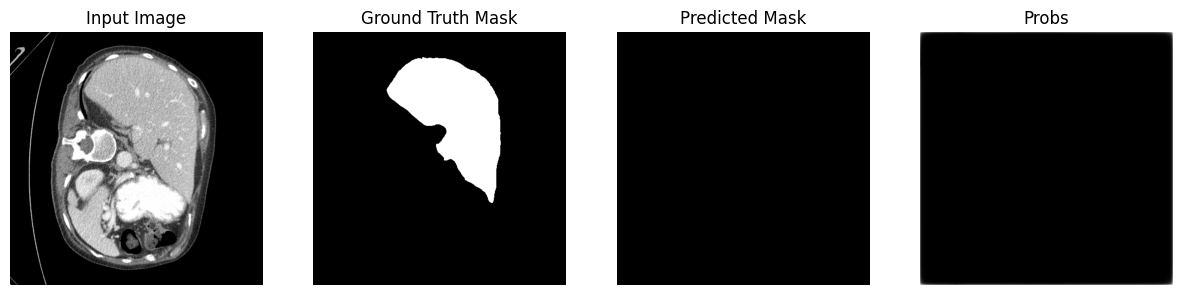

Training Epochs:   0%|          | 0/5 [00:06<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 11.75 GiB of which 128.81 MiB is free. Including non-PyTorch memory, this process has 9.24 GiB memory in use. Of the allocated memory 6.28 GiB is allocated by PyTorch, and 2.84 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [18]:
for epoch in tqdm(range(5), desc="Training Epochs"):
    # Each epoch has training and validation phase
    for phase in phases:
        if phase == "train":
            model.train()
            dataloader = train_loader
        elif phase == "val":
            model.eval()
            dataloader = val_loader
            all_val_preds = []
            all_val_masks = []

        running_loss = 0.0
        running_dice = 0.0

        for volumes, masks in tqdm(train_loader, desc=f"{phase.capitalize()} phase"):
            volumes = volumes.to(device)
            masks = masks.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(volumes)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                # --- PLOTTING CODE ---
                # Move tensors to CPU and detach from graph for plotting
                volumes_cpu = volumes.cpu().numpy()
                masks_cpu = masks.cpu().numpy()
                preds_cpu = preds.cpu().detach().numpy()
                probs_cpu = probs.cpu().detach().numpy()

                for i in range(volumes.size(0)):  # Iterate through batch
                    plt.figure(figsize=(15, 5))

                    # Plot Input Image
                    plt.subplot(1, 4, 1)
                    plt.imshow(volumes_cpu[i].squeeze(), cmap="gray")
                    plt.title("Input Image")
                    plt.axis("off")

                    # Plot Ground Truth Mask
                    plt.subplot(1, 4, 2)
                    plt.imshow(masks_cpu[i].squeeze(), cmap="gray")
                    plt.title("Ground Truth Mask")
                    plt.axis("off")

                    # Plot Predicted Mask
                    plt.subplot(1, 4, 3)
                    plt.imshow(preds_cpu[i].squeeze(), cmap="gray")
                    plt.title("Predicted Mask")
                    plt.axis("off")

                    plt.subplot(1, 4, 4)
                    plt.imshow(probs_cpu[i].squeeze(), cmap="gray")
                    plt.title("Probs")
                    plt.axis("off")

                    plt.show()
                    plt.close()
                    break
                # --- END PLOTTING ---
                # Calculate loss
                criterion = nn.BCEWithLogitsLoss()
                loss = criterion(outputs, masks)

                # Calculate Dice score
                dice = dice_coefficient(preds, masks)

                # Backward + optimize only in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * volumes.size(0)
            running_dice += dice * volumes.size(0)

            if phase == "val":
                all_val_preds.append(preds.view(-1).cpu())
                all_val_masks.append(masks.view(-1).cpu())

        # Calculate epoch metrics
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_dice = running_dice / len(dataloader.dataset)

        print(f"{phase} Loss: {epoch_loss:.4f} Dice: {epoch_dice:.4f}")